论文参考：

1. *Enhanced LSTM for Natural Language Inference* .2017
2. *Neural Architectures for Named Entity Recognition* .2017
3. *A Decomposable Attention Model for Natural Language Inference* .2016

代码参考：
1. [分散注意力网络解决推断问题](https://d2l.ai/chapter_natural-language-processing-applications/natural-language-inference-attention.html)


In [1]:
# module used
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy import data,datasets

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tqdm import tqdm

import spacy
import jieba 

In [4]:
# seed
SEED=2022
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic=True

MODE=0 # 0:try mode ,set little train_vector

In [5]:
# DataLoader


TEXT=data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm',lower=True)


# # use jieba( very slow)
# def tokenizer(text):    
#     return [wd for wd in jieba.cut(text, cut_all=False)]
# TEXT=data.Field(tokenize=tokenizer,lower=True)

LABEL=data.LabelField(sequential=False)

train_data,valid_data,test_data=datasets.SNLI.splits(TEXT,LABEL)

if MODE ==0:
    train_data.examples=train_data.examples[0:10000]


MIN_FREQ=2
#embedding number:[ 50,100,200,300] first try 100,and paper use 300.
EMBEDDING_DIM=300
TEXT.build_vocab(
    train_data,
    min_freq=MIN_FREQ,
    vectors="glove.6B.{}d".format(EMBEDDING_DIM),
    unk_init=torch.Tensor.normal_
)

LABEL.build_vocab(train_data)

BATCH_SIZE=32
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator,valid_iterator,test_iterator=data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size=BATCH_SIZE,
    device=DEVICE
)



In [86]:

# Model
class ESIM(nn.Module):
    def __init__(
        self,
        vocab_size, 
        embedding_dim, 
        hidden_dim, 
        output_dim, 
        bidFlag, 
        dropout
    ):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size,embedding_dim)
        self.lstm=nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=1,
            dropout=dropout,
            batch_first=True,
            bidirectional=bidFlag
        )
        self.lstm_decode=nn.LSTM(
            embedding_dim*8,
            hidden_dim,
            num_layers=1,
            dropout=dropout,
            batch_first=True,
            bidirectional=bidFlag
        )
        self.act=nn.Tanh()
        self.softmax=nn.Softmax(dim=1)
        self.mlp=nn.Linear(embedding_dim*8, output_dim)

    
    def forward(self, prem, hypo):

        #prem = [prem sent len, batch size]
        #hypo = [hypo sent len, batch size]
        prem_seq_len, batch_size = prem.shape
        hypo_seq_len, _ = hypo.shape

        #use batch first
        #prem = [prem sent len, batch size]
        #hypo = [hypo sent len, batch size]
        prem=prem.permute(1,0)
        hypo=hypo.permute(1,0)
      
        #embedded_prem = [batch size, prem sent len, embedding dim]
        #embedded_hypo = [batch size, hypo sent len, embedding dim]
        embedded_prem = self.embedding(prem)
        embedded_hypo = self.embedding(hypo)
        # print(embedded_prem.shape,embedded_hypo.shape)

        #hidden_prem = [batch size,prem sent len,embedding dim*2]
        #hidden_hypo = [batch size,hypo sent len,embedding dim*2]
        hidden_prem, (_, _)=self.lstm(embedded_prem)
        hidden_hypo, (_, _)=self.lstm(embedded_hypo)
        # print(hidden_prem.shape,hidden_hypo.shape)


        # e=[batch_size,prem sent len,hypo sent len ]
        e = torch.bmm(hidden_prem, hidden_hypo.permute(0, 2, 1))
        # print(e.shape)

        # alignment_prem=[batch size,prem sent len,embedding dim*2]
        # alignment_hypo=[batch size,prem sent len,embedding dim*2]
        alignment_prem=torch.bmm(F.softmax(e, dim=-1), hidden_hypo)
        alignment_hypo= torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), hidden_prem)
        # print(alignment_prem.shape,alignment_hypo.shape)

        # enhance_prem=[batch size,prem sent len,embedding dim*8]
        # enhance_hypo=[batch size,hypo sent len,embedding dim*8]
        enhance_prem=torch.cat((
            hidden_prem,
            alignment_prem,
            hidden_prem-alignment_prem,
            torch.mul(hidden_prem,alignment_prem)
        ),dim=2)

        enhance_hypo=torch.cat((
            hidden_hypo,
            alignment_hypo,
            hidden_hypo-alignment_hypo,
            torch.mul(hidden_hypo,alignment_hypo)
        ),dim=2)
        # print(enhance_prem.shape,enhance_hypo.shape)



        # compose_prem=[batch size,prem sent len,embedding dim*2]
        # compose_hypo=[batch size,hypo sent len,embedding dim*2]
        compose_prem,_ =self.lstm_decode(enhance_prem)
        compose_hypo,_ =self.lstm_decode(enhance_hypo)
        # print(compose_prem.shape,compose_hypo.shape)



        # pool_avg_prem=[batch size,embedding dim*2]
        # pool_max_prem=[batch size,embedding dim*2]
        # pool_avg_hypo=[batch size,embedding dim*2]
        # pool_max_hypo=[batch size,embedding dim*2]
        pool_avg_prem = compose_prem.mean(dim=1)
        pool_max_prem = compose_prem.max(dim=1).values
        pool_avg_hypo = compose_hypo.mean(dim=1)
        pool_max_hypo = compose_hypo.max(dim=1).values
        # print(pool_avg_prem.shape,
        #         pool_max_prem.shape,
        #         pool_avg_hypo.shape,
        #         pool_max_hypo.shape
        # )

        # pool=[batch size,embedding dim*8]
        pool=torch.cat((
                pool_avg_prem,
                pool_max_prem,
                pool_avg_hypo,
                pool_max_hypo
        ),dim=1)
        # print(pool.shape)

        # prediction=[batch size,embedding dim*8]
        prediction=self.act(pool)
        # print(prediction.shape)
        
        # prediction=[batch size,output dim]
        prediction=self.mlp(prediction)
        # print(prediction.shape)

        #prediction=[batch size, output dim]
        prediction =self.softmax(prediction)
        # print(prediction.shape)

        return prediction
       
        


# Model Parameter
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM=300
HIDDEN_DIM = 300
N_LSTM_LAYERS = 2
N_FC_LAYERS = 3
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
BID_FlAG=True
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Model init
model=ESIM(
    vocab_size=INPUT_DIM,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    bidFlag=BID_FlAG,
    output_dim=OUTPUT_DIM,
    dropout=DROPOUT,
     ).to(DEVICE)

# Embedding set
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

# dont no why use this ,set some vector to zero
# model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.requires_grad = True


# Optimizer and LossFunction
# use the paper best parameter
optimizer = optim.Adam(model.parameters(),lr=4e-4,betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss().to(DEVICE)

# Evaluation function 
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    correct=torch.tensor(correct.sum()).to(DEVICE)
    all=torch.tensor(y.shape[0]).to(DEVICE)
    return correct/ all

# test

# batch=next(iter(train_iterator))
# prem = batch.premise
# hypo = batch.hypothesis
# labels = batch.label
# predictions = model(prem, hypo)

# loss = criterion(predictions, labels)
                
# acc = categorical_accuracy(predictions, labels)
# loss.backward()

In [105]:
# some parmeters of the model to view

# total model trainable parameters
def count_parameters(model):

    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

# text vocab vectors shape
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)


The model has 15,002,103 trainable parameters
torch.Size([23551, 300])


In [88]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0  
    model.train() 
    for batch in tqdm(iterator):
        
        prem = batch.premise
        hypo = batch.hypothesis
        labels = batch.label
       
        optimizer.zero_grad()
        
        #prem = [prem sent len, batch size]
        #hypo = [hypo sent len, batch size]
        
        predictions = model(prem, hypo)
        

        #predictions = [batch size, output dim]
        #labels = [batch size]
        
        loss = criterion(predictions, labels)
                
        acc = categorical_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in tqdm(iterator):

            prem = batch.premise
            hypo = batch.hypothesis
            labels = batch.label
                        
            predictions = model(prem, hypo)
            
            loss = criterion(predictions, labels)
                
            acc = categorical_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



In [89]:
N_EPOCHS = 5

best_valid_loss = float('inf')


train_loss_list=[]
valid_loss_list=[]
train_acc_list=[]
valid_acc_list=[]

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/17168 [00:00<?, ?it/s]C:\Users\zoro\AppData\Local\Temp/ipykernel_23240/4147026850.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct=torch.tensor(correct.sum()).to(DEVICE)
100%|██████████| 308/308 [00:02<00:00, 130.09it/s]


Epoch: 01 | Epoch Time: 11m 51s
	Train Loss: 0.773 | Train Acc: 77.11%
	 Val. Loss: 0.721 |  Val. Acc: 82.61%


100%|██████████| 308/308 [00:02<00:00, 130.57it/s]


Epoch: 02 | Epoch Time: 11m 56s
	Train Loss: 0.712 | Train Acc: 83.52%
	 Val. Loss: 0.704 |  Val. Acc: 84.39%


100%|██████████| 308/308 [00:02<00:00, 133.08it/s]


Epoch: 03 | Epoch Time: 11m 59s
	Train Loss: 0.689 | Train Acc: 85.96%
	 Val. Loss: 0.697 |  Val. Acc: 85.12%


100%|██████████| 308/308 [00:02<00:00, 121.56it/s]


Epoch: 04 | Epoch Time: 12m 1s
	Train Loss: 0.673 | Train Acc: 87.57%
	 Val. Loss: 0.695 |  Val. Acc: 85.36%


100%|██████████| 308/308 [00:02<00:00, 123.66it/s]


Epoch: 05 | Epoch Time: 12m 50s
	Train Loss: 0.661 | Train Acc: 88.86%
	 Val. Loss: 0.695 |  Val. Acc: 85.37%


In [90]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

  0%|          | 0/307 [00:00<?, ?it/s]C:\Users\zoro\AppData\Local\Temp/ipykernel_23240/4147026850.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct=torch.tensor(correct.sum()).to(DEVICE)
100%|██████████| 307/307 [00:02<00:00, 116.22it/s]

Test Loss: 0.697 |  Test Acc: 85.05%


![](../pic/ESMI-loss-5.jpg)


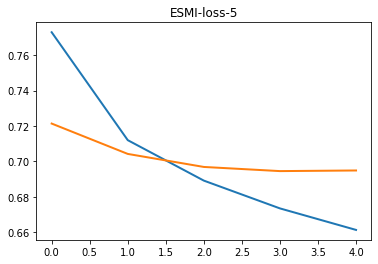

![](../pic/ESMI-acc-5.jpg)


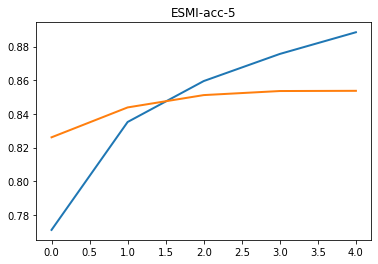

In [91]:
def drawpic(train_loss_list=[],test_loss_list=[],epoch_number=10,title='1',root_path='./'):
    # make data
    x = [i for i in range(epoch_number)]
    # plot
    fig, ax = plt.subplots()
    plt.title(title)
    ax.plot(x, train_loss_list, linewidth=2.0)
    ax.plot(x, test_loss_list, linewidth=2.0)
    path=root_path+title+'.jpg'
    print('![]({})'.format(path))
    plt.savefig(path)
    plt.show()
root_path='../pic/'
title='ESMI-loss-{}'.format(str(N_EPOCHS))

drawpic(train_loss_list=train_loss_list,test_loss_list=valid_loss_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

title='ESMI-acc-{}'.format(str(N_EPOCHS))

drawpic(train_loss_list=train_acc_list,test_loss_list=valid_acc_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

In [92]:
def predict_inference(premise, hypothesis, text_field, label_field, model, device):
    
    model.eval()
    
    if isinstance(premise, str):
        premise = text_field.tokenize(premise)
    
    if isinstance(hypothesis, str):
        hypothesis = text_field.tokenize(hypothesis)
    
    if text_field.lower:
        premise = [t.lower() for t in premise]
        hypothesis = [t.lower() for t in hypothesis]
        
    premise = [text_field.vocab.stoi[t] for t in premise]
    hypothesis = [text_field.vocab.stoi[t] for t in hypothesis]
    
    premise = torch.LongTensor(premise).unsqueeze(1).to(device)
    hypothesis = torch.LongTensor(hypothesis).unsqueeze(1).to(device)
    
    prediction = model(premise, hypothesis)
    
    prediction = prediction.argmax(dim=-1).item()
    
    return label_field.vocab.itos[prediction]


In [93]:
premise = 'a man sitting on a green bench.'
hypothesis = 'a woman sitting on a green bench.'
predict_inference(premise, hypothesis, TEXT, LABEL, model, DEVICE)

premise = 'a man sitting on a green bench.'
hypothesis = 'a person on a park bench'
predict_inference(premise, hypothesis, TEXT, LABEL, model, DEVICE)

'neutral'